## Train CNN and Bi LSTM Model

In [1]:
# !pip3 install fastText

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tqdm import tqdm
import nltk

##### Phase 1 : 
train =  Kirk train + kirk validation (5316 messages) \
test = TikTok + YouTube dataset (200 messages)

In [2]:
df_train = pd.concat([pd.read_csv("../Test_models/HatemojiBuild_from_Kirk/train.csv"), pd.read_csv("../Test_models/HatemojiBuild_from_Kirk/validation.csv")])
df_train = df_train.reset_index(drop=True)
df_test = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")

##### Phase 2 : 
train =  Kirk train + kirk validation (5908 messages) \
test = TikTok + YouTube dataset (200 messages)

In [3]:
df_train = pd.concat([pd.read_csv("../Test_models/HatemojiBuild_from_Kirk/train.csv"), pd.read_csv("../Test_models/HatemojiBuild_from_Kirk/validation.csv"),pd.read_csv("../Test_models/HatemojiBuild_from_Kirk/test.csv")])

df_train = df_train.reset_index(drop=True)
df_test = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")

In [4]:
# extract X and Y for training from Krik dataset
X_train = df_train["text"]
Y_train = df_train["label_gold"]

In [5]:
# convert label in test set to index (Hated==1 and Non-Hated==0)
Y_test = []
X_test = df_test["Comment"]
for i in df_test["Tag_Nalin"]:
  if i == "Hated":
    Y_test.append(1)
  else:
    Y_test.append(0)

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/srunnalin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# apply word tokenize using nltk
import collections
from nltk import word_tokenize
token2int = collections.defaultdict(lambda: len(token2int)+1)
tokenized_X_train = [word_tokenize(text) for text in X_train]
tokenized_X_test = [word_tokenize(text) for text in X_test]
int_X_train = [[token2int[token.lower()] for token in text] for text in tokenized_X_train]
int_X_test = [[token2int[token.lower()] for token in text] for text in tokenized_X_test]

In [8]:
int2token = dict()
for key, value in token2int.items():
    int2token[value] = key

## Vocabulary Size:
print("The Vocabulary size is:",len(token2int))

## Maximum text length
X_train_lengths = [len(text) for text in tokenized_X_train]
X_test_lengths = [len(text) for text in tokenized_X_test]
print("The maximum text length:", max(X_train_lengths))

The Vocabulary size is: 6220
The maximum text length: 55


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# convert dataset to tensor
max_len = 555

X_train = torch.zeros(len(X_train), max_len, dtype=torch.long)

for i, int_text in enumerate(int_X_train):
    if len(int_text) < max_len:
        int_text = int_text + [len(token2int)] * (max_len - len(int_text))

    X_train[i] = torch.LongTensor(int_text[:max_len])


Y_train = torch.LongTensor(Y_train)

print(X_train.size())
print(Y_train.size())

X_test = torch.zeros(len(X_test), max_len, dtype=torch.long)

for i, int_text in enumerate(int_X_test):
    if len(int_text) < max_len:
        int_text = int_text + [len(token2int)] * (max_len - len(int_text))

    X_test[i] = torch.LongTensor(int_text[:max_len])


Y_test = torch.LongTensor(Y_test)


print(X_test.size())
print(Y_test.size())

torch.Size([5908, 555])
torch.Size([5908])
torch.Size([200, 555])
torch.Size([200])


In [11]:
X_valid = X_test
Y_valid = Y_test

In [12]:
from torch.utils.data import TensorDataset, DataLoader
# batch_size = 32
batch_size = 64
# the TensorDataset is a ready to use class to represent data as list of tensors. 
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def perf(model, loader):
    y_pred_list = []
    y_true_list = []
    ## Define the loss
    criterion = nn.CrossEntropyLoss()

    ## No drop out
    model.eval()
    total_loss, correct, num = 0, 0, 0
    correct_predictions, total_predictions = 0, 0
    for x, y in loader:
      # print("this is x:", x)
      # print(x.shape)
      ## No gradient computation, weights remain unchanged
      with torch.no_grad():
        ## Compute the scofed for the instances in the input batch.
        y_scores = model(x)
        ## compute the loss
        predictions = torch.argmax(y_scores, dim=1)
        ## compute the predictions
        correct_predictions += sum(predictions == y).item()

        total_predictions += len(y) 
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        # print("y_pred:", y_pred)
        ## Update the batch loss.
        total_loss += loss.item()
        num += len(y)
        y_pred_list.extend(y_pred.tolist())
        y_true_list.extend(y.tolist())

    return total_loss / num, correct_predictions / total_predictions, y_pred_list, y_true_list

In [14]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)  # Learning rate scheduler

    train_losses = []  # List to store training losses
    valid_losses = []  # List to store validation losses
    best_f1_score = 0
    early_stop_counter = 0
    best_model_state_dict = None  # Variable to store the state_dict of the best model
    best_epoch = 0  # Variable to store the epoch when the best model was saved

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_samples = 0
        
        for x_data, y_data in train_loader:
            x_data = x_data.to(device)
            y_data = y_data.to(device)
            optimizer.zero_grad()
            y_pred = model(x_data)
            num_samples += len(y_pred)
            loss = criterion(y_pred, y_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        valid_loss, valid_acc, y_pred_list, y_true_list = perf(model, valid_loader)
        train_loss = total_loss / num_samples
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch {epoch + 1}/{epochs} | Train loss: {total_loss/num_samples:.4f} | Valid loss: {valid_loss:.4f} | Acc: {valid_acc:.4%}')
        print('Classification Report:')
        print(classification_report(y_true_list, y_pred_list, labels=[1, 0], digits=4))

        cm = confusion_matrix(y_true_list, y_pred_list, labels=[1, 0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
        disp.plot()
        plt.show()

        scheduler.step(valid_loss)  # Adjust learning rate based on validation loss

        # Calculate F1 score
        y_true = torch.tensor(y_true_list)
        y_pred = torch.tensor(y_pred_list)
        f1 = f1_score(y_true, y_pred, labels=[1, 0], average='weighted')
        # print(f"F1 score: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            early_stop_counter = 0
            best_model_state_dict = model.state_dict()  # Save the state_dict of the current best model
            best_epoch = epoch + 1  # Update the best epoch
        else:
            early_stop_counter += 1

        if early_stop_counter >= 20:  # Early stopping if validation loss doesn't improve for 10 consecutive epochs
            print("Early stopping...")
            break

    # Saving the best model
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, '../Model/deep_model/best_model.pt')
        print(f"Best model saved at epoch {best_epoch} with F1 score {best_f1_score}")

    # Plotting the loss curve
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load FastText Embedding Model

In [16]:
# Load pre-trained FastText word embeddings
import fasttext
import fasttext.util

# download pre-trained FastText word embeddings
# fasttext.util.download_model('en', if_exists='ignore')

# reduce embedding
pretrained_embeddings = fasttext.load_model('../Model/fasttext/cc.en.50.bin')

# Create the embedding matrix
embeddings = torch.zeros(len(token2int), 50).to(device)
for token, idx in token2int.items():
    if token in pretrained_embeddings.words:
      # print(token)
      embeddings[idx] = torch.tensor(pretrained_embeddings[token])

# Check for out-of-vocabulary tokens and assign random embeddings
for token, idx in token2int.items():
    if idx >= len(embeddings):
        if token != '':
          new_embedding = torch.rand(1, 50).to(device)
          embeddings = torch.cat([embeddings, new_embedding])

In [17]:
import torch.nn.functional as F
import fasttext
import fasttext.util
class CNN(nn.Module):
    # def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, pretrained_embeddings):
        super().__init__()
        # self.embed = nn.Embedding(vocab_size, embed_size)
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.conv1 = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        # self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)
        # self.conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)  # Add an additional convolutional layer
        # self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, num_classes)

        # self.batch_norm1 = nn.BatchNorm1d(hidden_size)  # Add batch normalization
        # self.batch_norm2 = nn.BatchNorm1d(hidden_size)  # Add batch normalization


    def forward(self, x):
        embed = self.embed(x)
        conv1 = F.relu(self.conv1(embed.transpose(1,2)))
        # conv2 = F.relu(self.conv2(conv1))
        # conv3 = F.relu(self.conv3(conv2))
        # conv4 = F.relu(self.conv3(conv3))
        # conv2 = F.relu(self.batch_norm1(self.conv2(conv1)))  # Apply batch normalization
        # conv3 = F.relu(self.batch_norm2(self.conv3(conv2)))  # Apply batch normalization
        pool = F.max_pool1d(conv1, conv1.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN(vocab_size = len(token2int), embed_size =50, 
                hidden_size = 64, num_classes=len(X_train.unique()),  pretrained_embeddings=embeddings)
# Set the embedding layer to non-trainable
cnn_model.embed.weight.requires_grad = False

In [18]:
cnn_model

CNN(
  (embed): Embedding(6221, 50)
  (conv1): Conv1d(50, 64, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=64, out_features=5854, bias=True)
)

In [19]:
device

device(type='cpu')

Epoch 1/50 | Train loss: 0.0108 | Valid loss: 0.0131 | Acc: 60.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6364    0.4900    0.5537       100
           0     0.5854    0.7200    0.6457       100

    accuracy                         0.6050       200
   macro avg     0.6109    0.6050    0.5997       200
weighted avg     0.6109    0.6050    0.5997       200



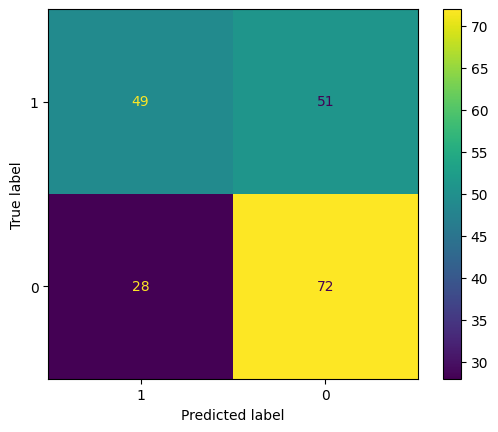

Epoch 2/50 | Train loss: 0.0108 | Valid loss: 0.0134 | Acc: 57.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5565    0.6900    0.6161       100
           0     0.5921    0.4500    0.5114       100

    accuracy                         0.5700       200
   macro avg     0.5743    0.5700    0.5637       200
weighted avg     0.5743    0.5700    0.5637       200



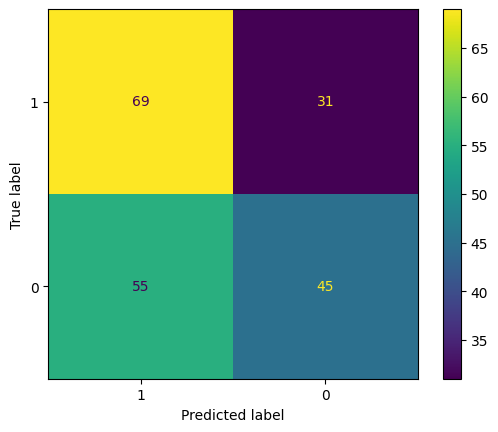

Epoch 3/50 | Train loss: 0.0108 | Valid loss: 0.0132 | Acc: 60.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6389    0.4600    0.5349       100
           0     0.5781    0.7400    0.6491       100

    accuracy                         0.6000       200
   macro avg     0.6085    0.6000    0.5920       200
weighted avg     0.6085    0.6000    0.5920       200



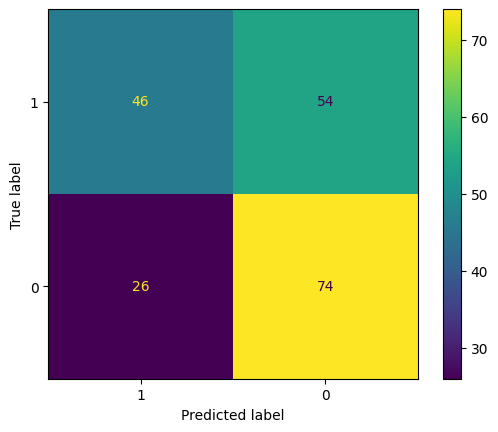

Epoch 4/50 | Train loss: 0.0108 | Valid loss: 0.0132 | Acc: 59.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6203    0.4900    0.5475       100
           0     0.5785    0.7000    0.6335       100

    accuracy                         0.5950       200
   macro avg     0.5994    0.5950    0.5905       200
weighted avg     0.5994    0.5950    0.5905       200



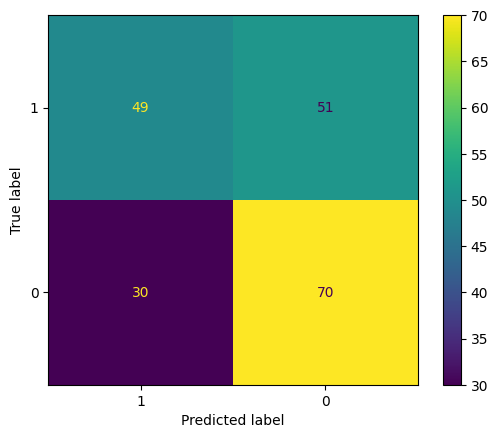

Epoch 5/50 | Train loss: 0.0107 | Valid loss: 0.0134 | Acc: 59.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.5865    0.6100    0.5980       100
           0     0.5938    0.5700    0.5816       100

    accuracy                         0.5900       200
   macro avg     0.5901    0.5900    0.5898       200
weighted avg     0.5901    0.5900    0.5898       200



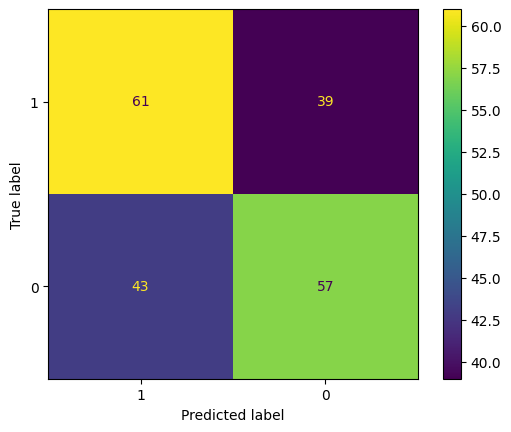

Epoch 6/50 | Train loss: 0.0107 | Valid loss: 0.0132 | Acc: 59.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6301    0.4600    0.5318       100
           0     0.5748    0.7300    0.6432       100

    accuracy                         0.5950       200
   macro avg     0.6025    0.5950    0.5875       200
weighted avg     0.6025    0.5950    0.5875       200



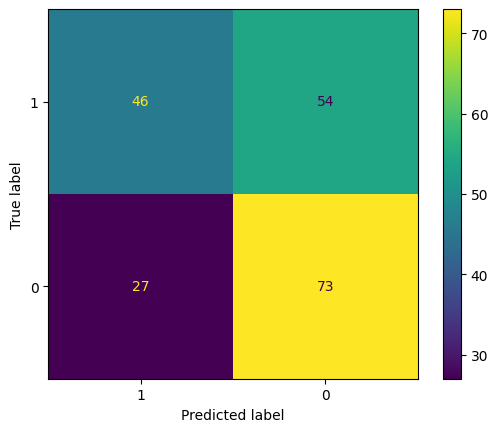

Epoch 7/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 55.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6341    0.2600    0.3688       100
           0     0.5346    0.8500    0.6564       100

    accuracy                         0.5550       200
   macro avg     0.5844    0.5550    0.5126       200
weighted avg     0.5844    0.5550    0.5126       200



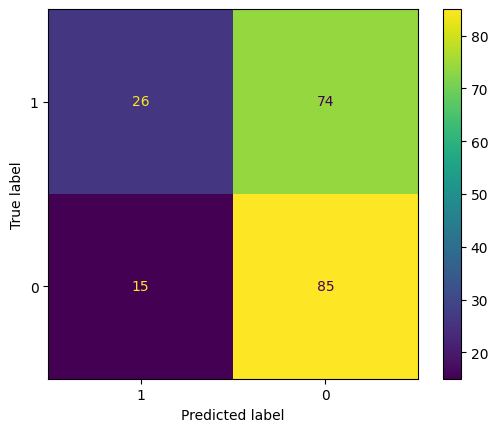

Epoch 8/50 | Train loss: 0.0106 | Valid loss: 0.0130 | Acc: 58.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6604    0.3500    0.4575       100
           0     0.5578    0.8200    0.6640       100

    accuracy                         0.5850       200
   macro avg     0.6091    0.5850    0.5607       200
weighted avg     0.6091    0.5850    0.5607       200



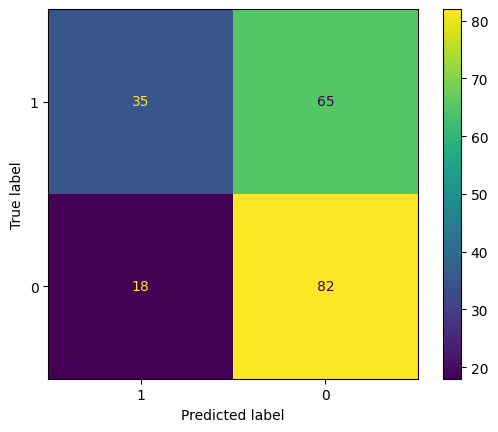

Epoch 9/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 55.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6190    0.2600    0.3662       100
           0     0.5316    0.8400    0.6512       100

    accuracy                         0.5500       200
   macro avg     0.5753    0.5500    0.5087       200
weighted avg     0.5753    0.5500    0.5087       200



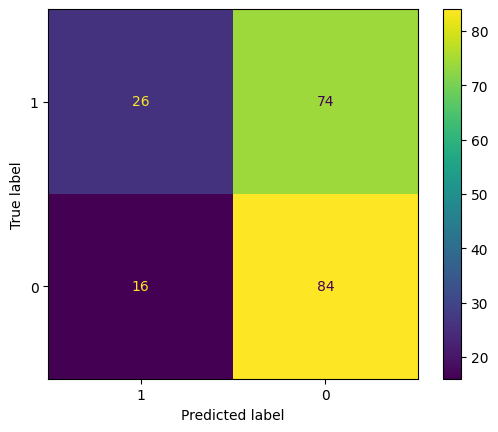

Epoch 10/50 | Train loss: 0.0107 | Valid loss: 0.0130 | Acc: 59.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6727    0.3700    0.4774       100
           0     0.5655    0.8200    0.6694       100

    accuracy                         0.5950       200
   macro avg     0.6191    0.5950    0.5734       200
weighted avg     0.6191    0.5950    0.5734       200



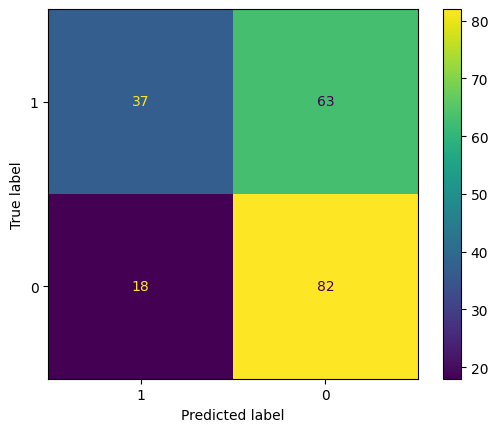

Epoch 11/50 | Train loss: 0.0107 | Valid loss: 0.0129 | Acc: 54.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6111    0.2200    0.3235       100
           0     0.5244    0.8600    0.6515       100

    accuracy                         0.5400       200
   macro avg     0.5678    0.5400    0.4875       200
weighted avg     0.5678    0.5400    0.4875       200



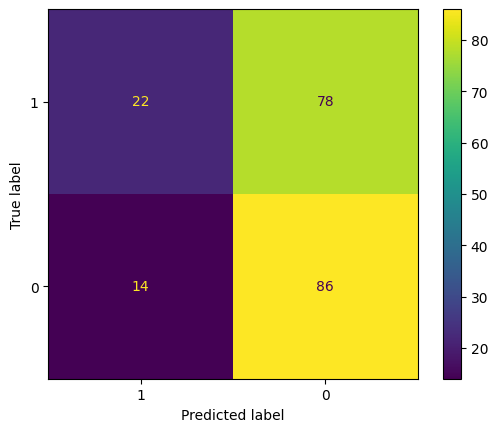

Epoch 12/50 | Train loss: 0.0106 | Valid loss: 0.0130 | Acc: 60.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6780    0.4000    0.5031       100
           0     0.5745    0.8100    0.6722       100

    accuracy                         0.6050       200
   macro avg     0.6262    0.6050    0.5877       200
weighted avg     0.6262    0.6050    0.5877       200



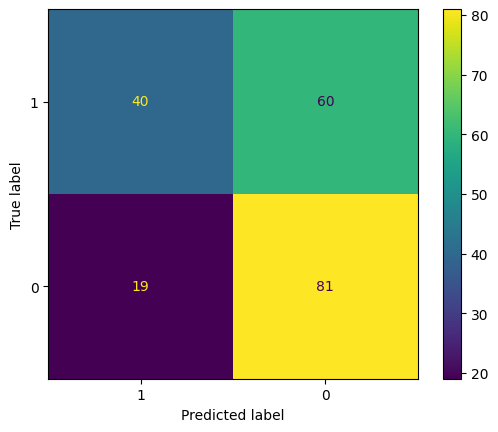

Epoch 13/50 | Train loss: 0.0106 | Valid loss: 0.0130 | Acc: 60.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6724    0.3900    0.4937       100
           0     0.5704    0.8100    0.6694       100

    accuracy                         0.6000       200
   macro avg     0.6214    0.6000    0.5815       200
weighted avg     0.6214    0.6000    0.5815       200



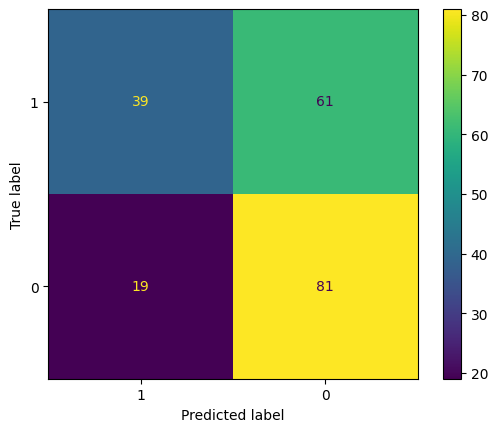

Epoch 14/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 55.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6316    0.2400    0.3478       100
           0     0.5309    0.8600    0.6565       100

    accuracy                         0.5500       200
   macro avg     0.5812    0.5500    0.5022       200
weighted avg     0.5812    0.5500    0.5022       200



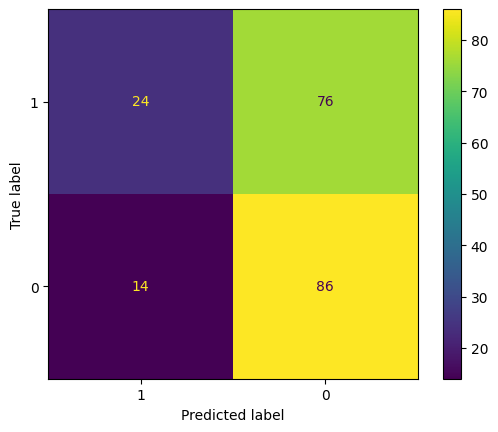

Epoch 15/50 | Train loss: 0.0106 | Valid loss: 0.0131 | Acc: 60.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6615    0.4300    0.5212       100
           0     0.5778    0.7800    0.6638       100

    accuracy                         0.6050       200
   macro avg     0.6197    0.6050    0.5925       200
weighted avg     0.6197    0.6050    0.5925       200



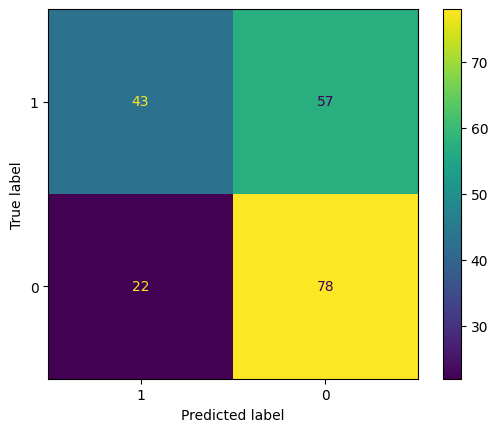

Epoch 16/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 57.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6522    0.3000    0.4110       100
           0     0.5455    0.8400    0.6614       100

    accuracy                         0.5700       200
   macro avg     0.5988    0.5700    0.5362       200
weighted avg     0.5988    0.5700    0.5362       200



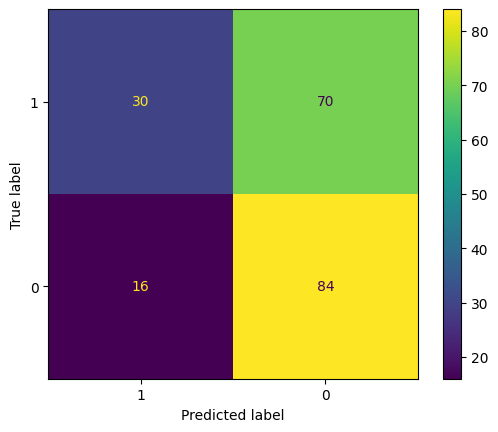

Epoch 17/50 | Train loss: 0.0106 | Valid loss: 0.0130 | Acc: 58.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6604    0.3500    0.4575       100
           0     0.5578    0.8200    0.6640       100

    accuracy                         0.5850       200
   macro avg     0.6091    0.5850    0.5607       200
weighted avg     0.6091    0.5850    0.5607       200



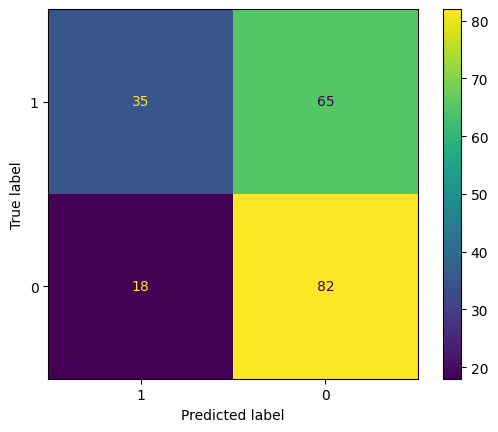

Epoch 18/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 58.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6667    0.3200    0.4324       100
           0     0.5526    0.8400    0.6667       100

    accuracy                         0.5800       200
   macro avg     0.6096    0.5800    0.5495       200
weighted avg     0.6096    0.5800    0.5495       200



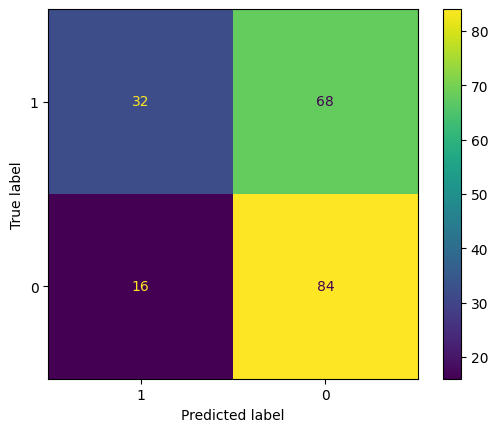

Epoch 19/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 58.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6538    0.3400    0.4474       100
           0     0.5541    0.8200    0.6613       100

    accuracy                         0.5800       200
   macro avg     0.6040    0.5800    0.5543       200
weighted avg     0.6040    0.5800    0.5543       200



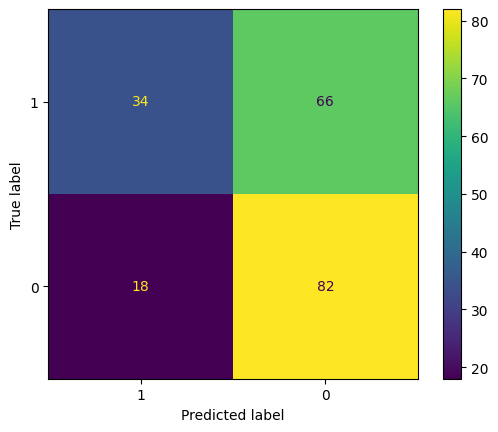

Epoch 20/50 | Train loss: 0.0106 | Valid loss: 0.0129 | Acc: 58.0000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6538    0.3400    0.4474       100
           0     0.5541    0.8200    0.6613       100

    accuracy                         0.5800       200
   macro avg     0.6040    0.5800    0.5543       200
weighted avg     0.6040    0.5800    0.5543       200



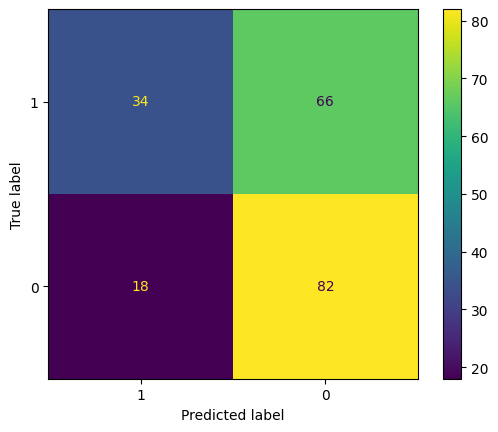

Epoch 21/50 | Train loss: 0.0106 | Valid loss: 0.0130 | Acc: 58.5000%
Classification Report:
              precision    recall  f1-score   support

           1     0.6604    0.3500    0.4575       100
           0     0.5578    0.8200    0.6640       100

    accuracy                         0.5850       200
   macro avg     0.6091    0.5850    0.5607       200
weighted avg     0.6091    0.5850    0.5607       200



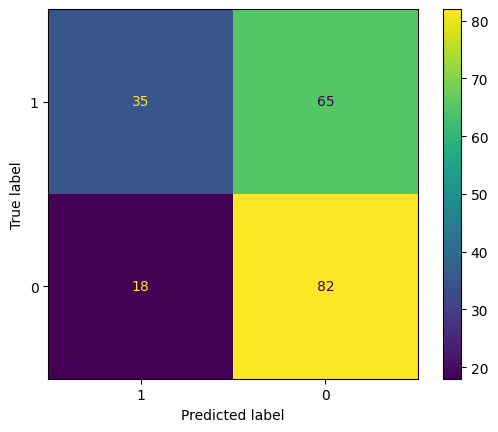

Early stopping...
Best model saved at epoch 1 with F1 score 0.5997061133490411


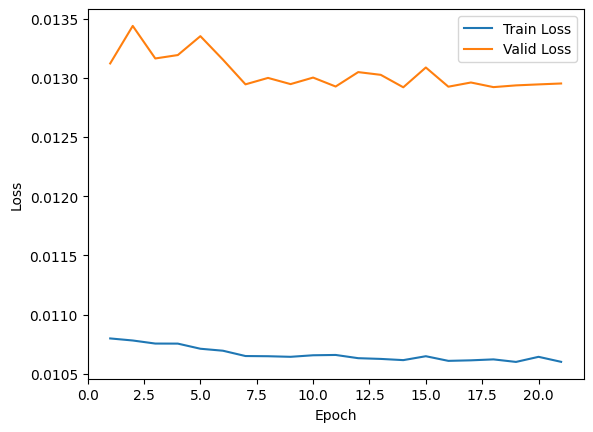

In [21]:
fit(cnn_model, 50)

In [2]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes,  pretrained_embeddings):
        super().__init__()
        
        # self.embed = nn.Embedding(vocab_size, embed_size)

        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings)
        
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)  # Replaced nn.GRU with nn.LSTM
        
        self.dropout = nn.Dropout(0.3)
        
        self.decision = nn.Linear(hidden_size, num_classes)
         
    def forward(self, x):
        x = x.to(device)
        embed = self.embed(x)
        
        output, (hidden, _) = self.rnn(embed)  # Unpack both hidden and cell state from LSTM
        
        drop = self.dropout(hidden[-1])  # Only consider the final hidden state
        
        return self.decision(drop.view(x.size(0), -1))
    # Set the embedding layer to non-trainable
cnn_model.embed.weight.requires_grad = False

In [32]:
lstm_model = RNN(vocab_size=len(token2int) + 1, embed_size=50, hidden_size=64, num_classes=len(Y_train.unique()),  pretrained_embeddings=embeddings)
lstm_model.to(device)


RNN(
  (embed): Embedding(6221, 50)
  (rnn): LSTM(50, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=64, out_features=2, bias=True)
)

In [71]:
fit(lstm_model, 5)

## Reduce FastText demension

In [150]:
ft = fasttext.load_model('../Model/fasttext/cc.en.300.bin')
embed_size = ft.get_dimension()
pretrained_embeddings = fasttext.util.reduce_model(ft, 32)
ft.get_dimension()

32

In [151]:
ft.save_model('../Model/fasttext/cc.en.32.bin')